In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [2]:
train=pd.read_csv('train.csv',sep='|')
test=pd.read_csv('test.csv',sep='|')

In [3]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [4]:
# for training set

train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']


# for test set

test['scannedLineItems'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']
test['pricePerScannedLineItem'] = test['grandTotal'] / test['scannedLineItems']
test['scansWithoutRegistrationPerScannedLineItem'] = test['scansWithoutRegistration'] / test['scannedLineItems']
test['quantityModificationsPerScannedLineItem'] = test['quantityModifications'] / test['scannedLineItems']
test['lineItemVoidsPerSecond'] = test['lineItemVoids'] / test['totalScanTimeInSeconds']
test['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
test['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
test['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
test['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
test['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
test['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

# Applying oversampling to dataset
- Classical Oversampling
- SMOTE Technique
- ADASYN Technique

Each one has a slightly different approach for generating synthetic instances
- Simply duplicated fraud instances
- ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier
- SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule.


Only run one of the following three cells to apply a specific oversampling method!
Attention!! If we use oversampling we have problems using k-fold cross validation. Since we have a faked test set. It would be better to oversample in every k-fold iteration. ALternatively we need to switch back to a fixed training, test split.  
This is not implemented yet!

In [46]:
#Initializing X_train, y_train
y_train = train['fraud']
X_train = train.drop('fraud',axis=1)

In [47]:
# !pip install imblearn  # might be necessary for installation
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [ ]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

In [50]:
X_train_res

array([[5.00000000e+00, 1.05400000e+03, 5.47000000e+01, ...,
        1.27970750e-01, 0.00000000e+00, 5.48446069e-02],
       [3.00000000e+00, 1.08000000e+02, 2.73600000e+01, ...,
        1.82748538e-01, 7.30994152e-02, 1.46198830e-01],
       [3.00000000e+00, 1.51600000e+03, 6.21600000e+01, ...,
        4.82625483e-02, 1.60875161e-01, 8.04375804e-02],
       ...,
       [1.00000000e+00, 9.10000000e+01, 2.60000000e-01, ...,
        3.07692308e+01, 2.30769231e+01, 1.53846154e+01],
       [1.00000000e+00, 5.18000000e+02, 4.86500000e+01, ...,
        1.84994861e-01, 2.05549846e-01, 6.16649538e-02],
       [1.00000000e+00, 1.69100000e+03, 9.03100000e+01, ...,
        6.64378253e-02, 5.53648544e-02, 1.10729709e-02]])

# Building model factory

In [6]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm.classes import OneClassSVM
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors.classification import RadiusNeighborsClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model.ridge import RidgeClassifierCV
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.linear_model.passive_aggressive import PassiveAggressiveClassifier
from sklearn.gaussian_process.gpc import GaussianProcessClassifier
from sklearn.ensemble.voting_classifier import VotingClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
# from sklearn.mixture import DPGMM
#from sklearn.mixture import GMM
#from sklearn.mixture import GaussianMixture
#from sklearn.mixture import VBGMM

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


model_tuning_factory = [
    GridSearchCV(LogisticRegression(max_iter = 10000), 
                 dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                     solver = ['newton-cg', 'lbfgs', 'liblinear'], 
                     fit_intercept = [True, False]),
                    #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(KNeighborsClassifier(), 
                 dict(n_neighbors = range(1,4),
                      weights = ['uniform', 'distance']),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(NearestCentroid(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(DecisionTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(ExtraTreesClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                      # n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score),    
    GridSearchCV(RandomForestClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score),    
    GridSearchCV(BernoulliNB(),
                 dict(binarize  = np.arange(0.0, 2.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(GaussianNB(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(AdaBoostClassifier(),
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(GradientBoostingClassifier(),
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 #     learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score),                     
    GridSearchCV(BaggingClassifier(), 
                 dict(),
                 #dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(Perceptron(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    GridSearchCV(LinearDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(QuadraticDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score),
    GridSearchCV(SVC(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score)
]           
                 
                 
iterations = 10                 
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(LogisticRegression(max_iter = 10000), 
                 dict(# penalty = ['l1','l2'],  # automatic regularization  -> option 'l1' doesnt work with all solvers and leads to errors
                       solver = ['newton-cg', 'lbfgs', 'liblinear'],
                       fit_intercept = [True, False]),
                    #  solver = ['lbfgs', 'liblinear', 'sag', 'saga']),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(KNeighborsClassifier(), 
                 dict(n_neighbors = range(1,4),
                      weights = ['uniform', 'distance']),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(NearestCentroid(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    RandomizedSearchCV(DecisionTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini']),
                     # max_depth = range(1,100)),
                 #     max_leaf_nodes = range(2,100)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(ExtraTreesClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score),    
    RandomizedSearchCV(RandomForestClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      n_estimators  = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),    
    RandomizedSearchCV(BernoulliNB(),
                 dict(binarize  = np.arange(0.0, 1.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations), 
    RandomizedSearchCV(GaussianNB(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score), 
    RandomizedSearchCV(AdaBoostClassifier(),
                 dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(GradientBoostingClassifier(),
                 dict(n_estimators = range(1,150),
                      learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),                    
    RandomizedSearchCV(BaggingClassifier(), 
                 dict(n_estimators = range(1,150)),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(Perceptron(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(LinearDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(QuadraticDiscriminantAnalysis(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations),
    RandomizedSearchCV(SVC(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 n_iter = iterations)
]

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)
loo = LeaveOneOut()

In [8]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [15]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Time needed", "Raw Model"])


# three types of data preparation: No preparation, MaxMinScaler, StandardScaler
for data_preparation_step in range(1,5):
    if (data_preparation_step == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_step == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_step == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_step == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"    

    for feature_count in range(1,len(list(X))+1):

        for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results
            
            start_time = time.time()
            
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]
            
            model.seed = 42
            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]
            
            end_time = time.time()
            
            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(end_time - start_time) + " seconds")

            result_table = result_table.append({
             "Model": model_name,
             "Data Preparation": data_preparation,
             "Feature Count": feature_count,
             "Features": best_feature_list.values,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,
             "Time needed": end_time - start_time,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)
    
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished LogisticRegression with No Scaling and 1 features after 0.30736517906188965 seconds
Finished KNeighborsClassifier with No Scaling and 1 features after 1.2340657711029053 seconds
Finished NearestCentroid with No Scaling and 1 features after 0.03793597221374512 seconds
Finished DecisionTreeClassifier with No Scaling and 1 features after 0.07280516624450684 seconds
Finished ExtraTreeClassifier with No Scaling and 1 features after 0.08178067207336426 seconds
Finished ExtraTreesClassifier with No Scaling and 1 features after 0.19510459899902344 seconds
Finished RandomForestClassifier with No Scaling and 1 features after 0.19481468200683594 seconds
Finished BernoulliNB with No Scaling and 1 features after 0.7994837760925293 seconds
Finished GaussianNB with No Scaling and 1 features after 0.03789806365966797 seconds
Finished AdaBoostClassifier with No Scaling and 1 features after 0.5162386894226074 seconds
Finished GradientBoostingClassifier with No Scaling and 1 features after 0.358

C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with No Scaling and 3 features after 2.014207363128662 seconds
Finished KNeighborsClassifier with No Scaling and 3 features after 1.171480655670166 seconds
Finished NearestCentroid with No Scaling and 3 features after 0.041005849838256836 seconds
Finished DecisionTreeClassifier with No Scaling and 3 features after 0.08900594711303711 seconds
Finished ExtraTreeClassifier with No Scaling and 3 features after 0.08199644088745117 seconds
Finished ExtraTreesClassifier with No Scaling and 3 features after 0.22898244857788086 seconds
Finished RandomForestClassifier with No Scaling and 3 features after 0.24790668487548828 seconds
Finished BernoulliNB with No Scaling and 3 features after 0.805607795715332 seconds
Finished GaussianNB with No Scaling and 3 features after 0.04288530349731445 seconds
Finished AdaBoostClassifier with No Scaling and 3 features after 0.6080224514007568 seconds
Finished GradientBoostingClassifier with No Scaling and 3 features after 0.636614

Finished AdaBoostClassifier with No Scaling and 8 features after 0.7870194911956787 seconds
Finished GradientBoostingClassifier with No Scaling and 8 features after 0.9286868572235107 seconds
Finished BaggingClassifier with No Scaling and 8 features after 0.2144455909729004 seconds
Finished Perceptron with No Scaling and 8 features after 0.04488372802734375 seconds
Finished LinearDiscriminantAnalysis with No Scaling and 8 features after 0.05782747268676758 seconds
Finished QuadraticDiscriminantAnalysis with No Scaling and 8 features after 0.04988598823547363 seconds
Finished SVC with No Scaling and 8 features after 2.7680673599243164 seconds
Finished LogisticRegression with No Scaling and 9 features after 3.909749746322632 seconds
Finished KNeighborsClassifier with No Scaling and 9 features after 1.3036248683929443 seconds
Finished NearestCentroid with No Scaling and 9 features after 0.04091978073120117 seconds
Finished DecisionTreeClassifier with No Scaling and 9 features after 0.1079

Finished ExtraTreeClassifier with No Scaling and 14 features after 0.0838325023651123 seconds
Finished ExtraTreesClassifier with No Scaling and 14 features after 0.2535686492919922 seconds
Finished RandomForestClassifier with No Scaling and 14 features after 0.34886765480041504 seconds
Finished BernoulliNB with No Scaling and 14 features after 0.8597526550292969 seconds
Finished GaussianNB with No Scaling and 14 features after 0.0448908805847168 seconds
Finished AdaBoostClassifier with No Scaling and 14 features after 1.0742161273956299 seconds
Finished GradientBoostingClassifier with No Scaling and 14 features after 1.3425347805023193 seconds
Finished BaggingClassifier with No Scaling and 14 features after 0.3181757926940918 seconds
Finished Perceptron with No Scaling and 14 features after 0.04687929153442383 seconds
Finished LinearDiscriminantAnalysis with No Scaling and 14 features after 0.061847686767578125 seconds
Finished QuadraticDiscriminantAnalysis with No Scaling and 14 featu

Finished SVC with No Scaling and 19 features after 3.396784782409668 seconds
Finished LogisticRegression with No Scaling and 20 features after 12.942198991775513 seconds
Finished KNeighborsClassifier with No Scaling and 20 features after 1.6507079601287842 seconds
Finished NearestCentroid with No Scaling and 20 features after 0.04388284683227539 seconds
Finished DecisionTreeClassifier with No Scaling and 20 features after 0.18450593948364258 seconds
Finished ExtraTreeClassifier with No Scaling and 20 features after 0.090057373046875 seconds
Finished ExtraTreesClassifier with No Scaling and 20 features after 0.2755429744720459 seconds
Finished RandomForestClassifier with No Scaling and 20 features after 0.4163355827331543 seconds
Finished BernoulliNB with No Scaling and 20 features after 1.207787275314331 seconds
Finished GaussianNB with No Scaling and 20 features after 0.05485343933105469 seconds
Finished AdaBoostClassifier with No Scaling and 20 features after 1.4393868446350098 secon

C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with MinMaxScaler and 3 features after 2.503063917160034 seconds
Finished KNeighborsClassifier with MinMaxScaler and 3 features after 1.248378038406372 seconds
Finished NearestCentroid with MinMaxScaler and 3 features after 0.04291820526123047 seconds
Finished DecisionTreeClassifier with MinMaxScaler and 3 features after 0.08902502059936523 seconds
Finished ExtraTreeClassifier with MinMaxScaler and 3 features after 0.0789804458618164 seconds
Finished ExtraTreesClassifier with MinMaxScaler and 3 features after 0.23166465759277344 seconds
Finished RandomForestClassifier with MinMaxScaler and 3 features after 0.24678421020507812 seconds
Finished BernoulliNB with MinMaxScaler and 3 features after 0.7983744144439697 seconds
Finished GaussianNB with MinMaxScaler and 3 features after 0.04394245147705078 seconds
Finished AdaBoostClassifier with MinMaxScaler and 3 features after 0.6273329257965088 seconds
Finished GradientBoostingClassifier with MinMaxScaler and 3 fe

Finished BernoulliNB with MinMaxScaler and 8 features after 0.828862190246582 seconds
Finished GaussianNB with MinMaxScaler and 8 features after 0.043883562088012695 seconds
Finished AdaBoostClassifier with MinMaxScaler and 8 features after 0.7719078063964844 seconds
Finished GradientBoostingClassifier with MinMaxScaler and 8 features after 0.9194040298461914 seconds
Finished BaggingClassifier with MinMaxScaler and 8 features after 0.21178460121154785 seconds
Finished Perceptron with MinMaxScaler and 8 features after 0.04525899887084961 seconds
Finished LinearDiscriminantAnalysis with MinMaxScaler and 8 features after 0.052860260009765625 seconds
Finished QuadraticDiscriminantAnalysis with MinMaxScaler and 8 features after 0.04601287841796875 seconds
Finished SVC with MinMaxScaler and 8 features after 2.7460734844207764 seconds
Finished LogisticRegression with MinMaxScaler and 9 features after 4.324669599533081 seconds
Finished KNeighborsClassifier with MinMaxScaler and 9 features afte

Finished QuadraticDiscriminantAnalysis with MinMaxScaler and 13 features after 0.060849905014038086 seconds
Finished SVC with MinMaxScaler and 13 features after 3.0321242809295654 seconds
Finished LogisticRegression with MinMaxScaler and 14 features after 4.489243030548096 seconds
Finished KNeighborsClassifier with MinMaxScaler and 14 features after 1.4054160118103027 seconds
Finished NearestCentroid with MinMaxScaler and 14 features after 0.04188418388366699 seconds
Finished DecisionTreeClassifier with MinMaxScaler and 14 features after 0.14538073539733887 seconds
Finished ExtraTreeClassifier with MinMaxScaler and 14 features after 0.08688879013061523 seconds
Finished ExtraTreesClassifier with MinMaxScaler and 14 features after 0.25409603118896484 seconds
Finished RandomForestClassifier with MinMaxScaler and 14 features after 0.36403799057006836 seconds
Finished BernoulliNB with MinMaxScaler and 14 features after 0.9036612510681152 seconds
Finished GaussianNB with MinMaxScaler and 14 

Finished ExtraTreesClassifier with MinMaxScaler and 19 features after 0.2645411491394043 seconds
Finished RandomForestClassifier with MinMaxScaler and 19 features after 0.4300057888031006 seconds
Finished BernoulliNB with MinMaxScaler and 19 features after 0.8918802738189697 seconds
Finished GaussianNB with MinMaxScaler and 19 features after 0.057845354080200195 seconds
Finished AdaBoostClassifier with MinMaxScaler and 19 features after 1.4317877292633057 seconds
Finished GradientBoostingClassifier with MinMaxScaler and 19 features after 1.7557618618011475 seconds
Finished BaggingClassifier with MinMaxScaler and 19 features after 0.45803332328796387 seconds
Finished Perceptron with MinMaxScaler and 19 features after 0.05784916877746582 seconds
Finished LinearDiscriminantAnalysis with MinMaxScaler and 19 features after 0.08700251579284668 seconds
Finished QuadraticDiscriminantAnalysis with MinMaxScaler and 19 features after 0.08676743507385254 seconds
Finished SVC with MinMaxScaler and 

C:\Users\ahuem\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Finished LogisticRegression with StandardScaler and 3 features after 2.72412371635437 seconds
Finished KNeighborsClassifier with StandardScaler and 3 features after 1.3216838836669922 seconds
Finished NearestCentroid with StandardScaler and 3 features after 0.04288482666015625 seconds
Finished DecisionTreeClassifier with StandardScaler and 3 features after 0.09075736999511719 seconds
Finished ExtraTreeClassifier with StandardScaler and 3 features after 0.08078336715698242 seconds
Finished ExtraTreesClassifier with StandardScaler and 3 features after 0.22274231910705566 seconds
Finished RandomForestClassifier with StandardScaler and 3 features after 0.24401569366455078 seconds
Finished BernoulliNB with StandardScaler and 3 features after 0.7967596054077148 seconds
Finished GaussianNB with StandardScaler and 3 features after 0.04287314414978027 seconds
Finished AdaBoostClassifier with StandardScaler and 3 features after 0.5975823402404785 seconds
Finished GradientBoostingClassifier with 

Finished ExtraTreesClassifier with StandardScaler and 8 features after 0.24434638023376465 seconds
Finished RandomForestClassifier with StandardScaler and 8 features after 0.2872591018676758 seconds
Finished BernoulliNB with StandardScaler and 8 features after 0.834766149520874 seconds
Finished GaussianNB with StandardScaler and 8 features after 0.04486894607543945 seconds
Finished AdaBoostClassifier with StandardScaler and 8 features after 0.7719619274139404 seconds
Finished GradientBoostingClassifier with StandardScaler and 8 features after 0.9135603904724121 seconds
Finished BaggingClassifier with StandardScaler and 8 features after 0.21143388748168945 seconds
Finished Perceptron with StandardScaler and 8 features after 0.04487776756286621 seconds
Finished LinearDiscriminantAnalysis with StandardScaler and 8 features after 0.05382990837097168 seconds
Finished QuadraticDiscriminantAnalysis with StandardScaler and 8 features after 0.04587721824645996 seconds
Finished SVC with Standard

Finished GradientBoostingClassifier with StandardScaler and 13 features after 1.2771339416503906 seconds
Finished BaggingClassifier with StandardScaler and 13 features after 0.30113744735717773 seconds
Finished Perceptron with StandardScaler and 13 features after 0.04890084266662598 seconds
Finished LinearDiscriminantAnalysis with StandardScaler and 13 features after 0.07452034950256348 seconds
Finished QuadraticDiscriminantAnalysis with StandardScaler and 13 features after 0.0468747615814209 seconds
Finished SVC with StandardScaler and 13 features after 3.055584669113159 seconds
Finished LogisticRegression with StandardScaler and 14 features after 3.8326759338378906 seconds
Finished KNeighborsClassifier with StandardScaler and 14 features after 1.463881254196167 seconds
Finished NearestCentroid with StandardScaler and 14 features after 0.04194474220275879 seconds
Finished DecisionTreeClassifier with StandardScaler and 14 features after 0.1442415714263916 seconds
Finished ExtraTreeClas

Finished SVC with StandardScaler and 18 features after 3.2753183841705322 seconds
Finished LogisticRegression with StandardScaler and 19 features after 11.697855472564697 seconds
Finished KNeighborsClassifier with StandardScaler and 19 features after 1.6886622905731201 seconds
Finished NearestCentroid with StandardScaler and 19 features after 0.04396367073059082 seconds
Finished DecisionTreeClassifier with StandardScaler and 19 features after 0.18216991424560547 seconds
Finished ExtraTreeClassifier with StandardScaler and 19 features after 0.0849766731262207 seconds
Finished ExtraTreesClassifier with StandardScaler and 19 features after 0.2658376693725586 seconds
Finished RandomForestClassifier with StandardScaler and 19 features after 0.4191756248474121 seconds
Finished BernoulliNB with StandardScaler and 19 features after 0.8740894794464111 seconds
Finished GaussianNB with StandardScaler and 19 features after 0.09899282455444336 seconds
Finished AdaBoostClassifier with StandardScaler

Finished BernoulliNB with LogScaler and 4 features after 0.8111882209777832 seconds
Finished GaussianNB with LogScaler and 4 features after 0.04390978813171387 seconds
Finished AdaBoostClassifier with LogScaler and 4 features after 0.6389491558074951 seconds
Finished GradientBoostingClassifier with LogScaler and 4 features after 0.6659688949584961 seconds
Finished BaggingClassifier with LogScaler and 4 features after 0.1579756736755371 seconds
Finished Perceptron with LogScaler and 4 features after 0.04459333419799805 seconds
Finished LinearDiscriminantAnalysis with LogScaler and 4 features after 0.07679438591003418 seconds
Finished QuadraticDiscriminantAnalysis with LogScaler and 4 features after 0.04288220405578613 seconds
Finished SVC with LogScaler and 4 features after 0.4819808006286621 seconds
Finished LogisticRegression with LogScaler and 5 features after 0.920107364654541 seconds
Finished KNeighborsClassifier with LogScaler and 5 features after 1.3530497550964355 seconds
Finish

Finished KNeighborsClassifier with LogScaler and 10 features after 1.457259178161621 seconds
Finished NearestCentroid with LogScaler and 10 features after 0.04428553581237793 seconds
Finished DecisionTreeClassifier with LogScaler and 10 features after 0.1240839958190918 seconds
Finished ExtraTreeClassifier with LogScaler and 10 features after 0.0839684009552002 seconds
Finished ExtraTreesClassifier with LogScaler and 10 features after 0.24390888214111328 seconds
Finished RandomForestClassifier with LogScaler and 10 features after 0.33296704292297363 seconds
Finished BernoulliNB with LogScaler and 10 features after 0.8280510902404785 seconds
Finished GaussianNB with LogScaler and 10 features after 0.04299139976501465 seconds
Finished AdaBoostClassifier with LogScaler and 10 features after 0.8899457454681396 seconds
Finished GradientBoostingClassifier with LogScaler and 10 features after 1.0729320049285889 seconds
Finished BaggingClassifier with LogScaler and 10 features after 0.25418663

Finished GradientBoostingClassifier with LogScaler and 15 features after 1.4264678955078125 seconds
Finished BaggingClassifier with LogScaler and 15 features after 0.347149133682251 seconds
Finished Perceptron with LogScaler and 15 features after 0.08676338195800781 seconds
Finished LinearDiscriminantAnalysis with LogScaler and 15 features after 0.09301924705505371 seconds
Finished QuadraticDiscriminantAnalysis with LogScaler and 15 features after 0.05966067314147949 seconds
Finished SVC with LogScaler and 15 features after 3.1276888847351074 seconds
Finished LogisticRegression with LogScaler and 16 features after 8.2685706615448 seconds
Finished KNeighborsClassifier with LogScaler and 16 features after 1.656970739364624 seconds
Finished NearestCentroid with LogScaler and 16 features after 0.04388236999511719 seconds
Finished DecisionTreeClassifier with LogScaler and 16 features after 0.16655397415161133 seconds
Finished ExtraTreeClassifier with LogScaler and 16 features after 0.090757

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Time needed,Raw Model
544,LogisticRegression,MinMaxScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.804502,"LogisticRegression(C=1.0, class_weight=None, d..."
832,LogisticRegression,StandardScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.327156,"LogisticRegression(C=1.0, class_weight=None, d..."
192,LogisticRegression,No Scaling,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.211324,"LogisticRegression(C=1.0, class_weight=None, d..."
864,LogisticRegression,StandardScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.537747,"LogisticRegression(C=1.0, class_weight=None, d..."
1136,LogisticRegression,LogScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'lbfgs'}",0.162320,0.119850,7.004890,"LogisticRegression(C=1.0, class_weight=None, d..."
224,LogisticRegression,No Scaling,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.044688,"LogisticRegression(C=1.0, class_weight=None, d..."
512,LogisticRegression,MinMaxScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.014032,"LogisticRegression(C=1.0, class_weight=None, d..."
144,LogisticRegression,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,4.044143,"LogisticRegression(C=1.0, class_weight=None, d..."
464,LogisticRegression,MinMaxScaler,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,4.086326,"LogisticRegression(C=1.0, class_weight=None, d..."
496,LogisticRegression,MinMaxScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,3.878505,"LogisticRegression(C=1.0, class_weight=None, d..."


# Restore the saved result table to avoid recomputation

In [17]:
result_table.to_pickle("result_table_training_set.pkl")
# result_table = pd.read_pickle("result_table_training_set.pkl")

In [16]:
result_table = result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

result_table.to_excel("Result-Train Set.xlsx")

result_table

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Time needed,Raw Model
544,LogisticRegression,MinMaxScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.804502,"LogisticRegression(C=1.0, class_weight=None, d..."
832,LogisticRegression,StandardScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.327156,"LogisticRegression(C=1.0, class_weight=None, d..."
192,LogisticRegression,No Scaling,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.211324,"LogisticRegression(C=1.0, class_weight=None, d..."
864,LogisticRegression,StandardScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,4.537747,"LogisticRegression(C=1.0, class_weight=None, d..."
1136,LogisticRegression,LogScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'lbfgs'}",0.162320,0.119850,7.004890,"LogisticRegression(C=1.0, class_weight=None, d..."
224,LogisticRegression,No Scaling,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.044688,"LogisticRegression(C=1.0, class_weight=None, d..."
512,LogisticRegression,MinMaxScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.014032,"LogisticRegression(C=1.0, class_weight=None, d..."
144,LogisticRegression,No Scaling,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,4.044143,"LogisticRegression(C=1.0, class_weight=None, d..."
464,LogisticRegression,MinMaxScaler,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,4.086326,"LogisticRegression(C=1.0, class_weight=None, d..."
496,LogisticRegression,MinMaxScaler,12,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.156998,0.126081,3.878505,"LogisticRegression(C=1.0, class_weight=None, d..."


In [18]:
result_table_aggregated = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Time needed", "Raw Model"])


for model in list(set(result_table["Model"].values)):
    sub_table = result_table[result_table["Model"] == model]
    result_table_aggregated = result_table_aggregated.append({
        "Model": model,
        "Data Preparation": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Data Preparation"],
        "Feature Count": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Feature Count"],
        "Features": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Features"],
        "Optimal Parameters": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"],
        "Monetary Value Per Instance - Mean": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Monetary Value Per Instance - Mean"],
        "Monetary Value Per Instance - Standard Deviation": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Monetary Value Per Instance - Standard Deviation"],
        "Time needed":  sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Time needed"],
        "Raw Model": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
        }, ignore_index=True)

result_table_aggregated.to_excel("Result-Train Set-Aggregated.xlsx")

result_table_aggregated.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Time needed,Raw Model
2,LogisticRegression,MinMaxScaler,15,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'fit_intercept': True, 'solver': 'newton-cg'}",0.162320,0.113088,5.804502,"LogisticRegression(C=1.0, class_weight=None, d..."
3,GradientBoostingClassifier,LogScaler,9,"[trustLevel, totalScanTimeInSeconds, valuePerS...",{},0.117084,0.121028,1.051988,([DecisionTreeRegressor(criterion='friedman_ms...
13,AdaBoostClassifier,LogScaler,13,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.106440,0.125820,1.028768,"(DecisionTreeClassifier(class_weight=None, cri..."
9,ExtraTreesClassifier,MinMaxScaler,10,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'criterion': 'gini'},0.093135,0.102196,0.250456,"(ExtraTreeClassifier(class_weight=None, criter..."
15,RandomForestClassifier,LogScaler,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'criterion': 'entropy'},0.079830,0.099503,0.344091,"(DecisionTreeClassifier(class_weight=None, cri..."
5,BaggingClassifier,LogScaler,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},0.063864,0.123027,0.263884,"(DecisionTreeClassifier(class_weight=None, cri..."
6,DecisionTreeClassifier,StandardScaler,20,"[trustLevel, totalScanTimeInSeconds, grandTota...",{'criterion': 'gini'},0.021288,0.196769,0.202020,"DecisionTreeClassifier(class_weight=None, crit..."
4,LinearDiscriminantAnalysis,LogScaler,11,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{},-0.063864,0.112533,0.078863,"LinearDiscriminantAnalysis(n_components=None, ..."
14,QuadraticDiscriminantAnalysis,No Scaling,3,"[trustLevel, totalScanTimeInSeconds, scannedLi...",{},-0.082491,0.220512,0.042893,"QuadraticDiscriminantAnalysis(priors=None, reg..."
11,GaussianNB,StandardScaler,3,"[trustLevel, totalScanTimeInSeconds, scannedLi...",{},-0.093135,0.184733,0.042873,"GaussianNB(priors=None, var_smoothing=1e-09)"


Text(0, 0.5, 'Monetary Value Per Instance - Mean')

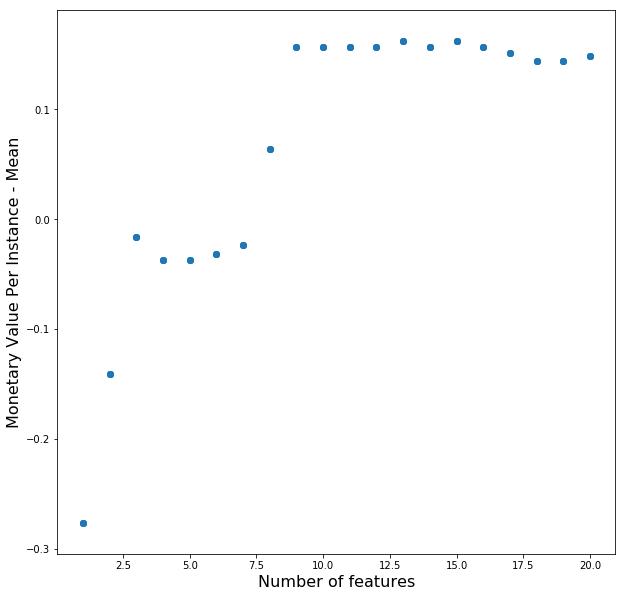

In [189]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table[result_table["Model"] == "LogisticRegression"]["Feature Count"],
         result_table[result_table["Model"] == "LogisticRegression"]["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [196]:
best_model = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Features"]

print(best_model)
print(best_model_features)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)
['trustLevel' 'totalScanTimeInSeconds' 'lineItemVoids'
 'scansWithoutRegistration' 'scannedLineItemsPerSecond' 'valuePerSecond'
 'lineItemVoidsPerPosition' 'scannedLineItems' 'pricePerScannedLineItem'
 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem' 'lineItemVoidsPerSecond'
 'quantityModificationsPerSecond']


In [195]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm, y_holdout):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(score, 'for ', len(y_holdout), ' instances in the test set')
        print(score/len(y_holdout), ' per instance in the test set')
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm, Y)

True negative:  1770
False positive:  5
False negative:  8
True positive:  96
315 for  1879  instances in the test set
0.16764236295902077  per instance in the test set
